In [ ]:
!pip install transformers datasets torch scikit-learn tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


<ipython-input-2-b2a8342039df>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  heatmap[i, j] = predictions[idx]


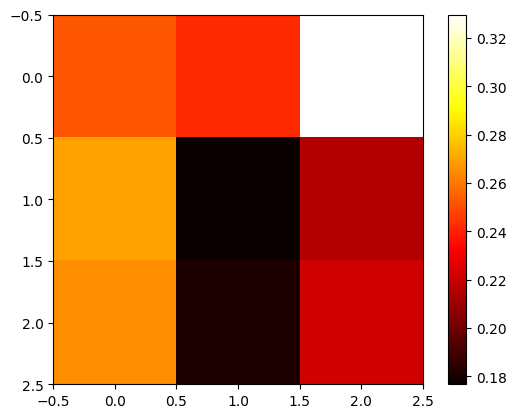

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt

# Load and preprocess image
def load_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize
    return image

# Break image into tiles
def create_image_tiles(image, tile_size=(64, 64)):
    h, w, _ = image.shape
    tiles = []
    for i in range(0, h, tile_size[0]):
        for j in range(0, w, tile_size[1]):
            tile = image[i:i+tile_size[0], j:j+tile_size[1]]
            if tile.shape[:2] == tile_size:
                tiles.append(tile)
    return np.array(tiles)

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
for layer in base_model.layers:
    layer.trainable = False

# Classification model
classification_model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Probability of cat presence
])
classification_model.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Regression model for bounding box
regression_model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(4)  # Bounding box coordinates (x_min, y_min, x_max, y_max)
])
regression_model.compile(optimizer=SGD(learning_rate=0.01), loss=MeanSquaredError())

# Function to create a heatmap
def generate_heatmap(predictions, image_shape, tile_size=(64, 64)):
    heatmap = np.zeros((image_shape[0] // tile_size[0], image_shape[1] // tile_size[1]))
    idx = 0
    for i in range(heatmap.shape[0]):
        for j in range(heatmap.shape[1]):
            heatmap[i, j] = predictions[idx]
            idx += 1
    return heatmap

# Load and process an example image
image_path = '/content/images.jpeg'  # Update with actual path
image = load_image(image_path)
tiles = create_image_tiles(image)

# Predict cat presence
predictions = classification_model.predict(tiles)
heatmap = generate_heatmap(predictions, image.shape)

# Display heatmap
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

# Predict bounding box (assuming training has been done)
# bounding_box = regression_model.predict(image.reshape(1, 224, 224, 3))

# Save heatmap as an image
plt.imsave("heatmap.jpg", heatmap, cmap="hot")


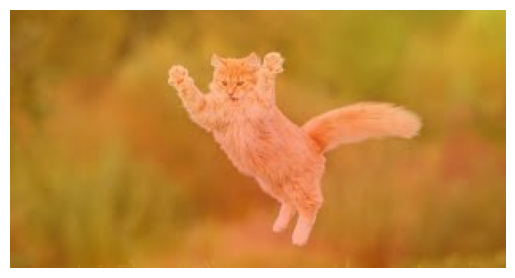

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the original image
img = cv2.imread("images.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Resize heatmap to match image size
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# Apply colormap
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

# Blend heatmap with original image
overlay = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

# Show the result
plt.imshow(overlay)
plt.axis("off")
plt.show()

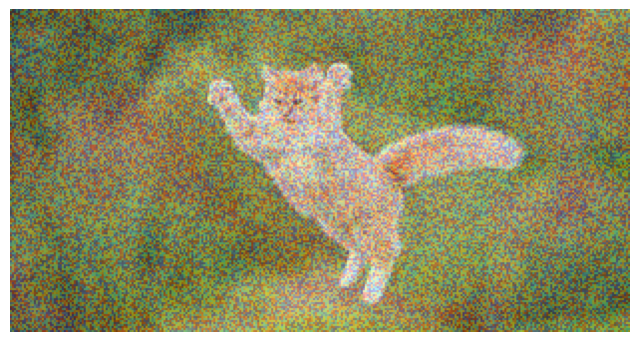

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "images.jpeg"  # Update if needed
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Load or generate heatmap (Make sure this comes from your model!)
heatmap = np.random.rand(img.shape[0], img.shape[1])  # Replace with actual heatmap data

# Normalize heatmap to range [0, 1]
heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

# Resize heatmap to match image size
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# Convert to 8-bit scale
heatmap_resized = np.uint8(255 * heatmap_resized)

# Apply colormap
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Blend heatmap with original image (adjust weights if needed)
overlay = cv2.addWeighted(img, 0.7, heatmap_color, 0.3, 0)

# Display the result
plt.figure(figsize=(8, 6))
plt.imshow(overlay)
plt.axis("off")
plt.show()


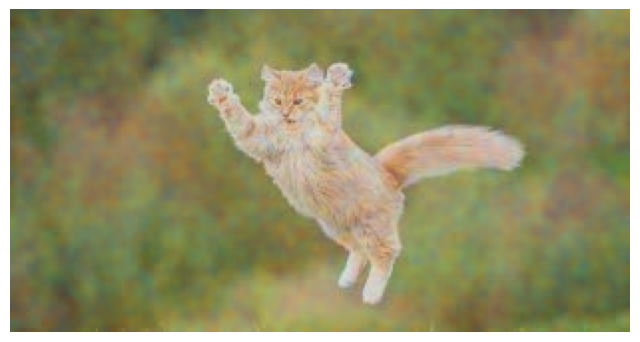

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "images.jpeg"  # Update path
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Simulated heatmap data (Replace this with your actual activation heatmap)
heatmap = np.random.rand(img.shape[0], img.shape[1])  # Dummy data

# Normalize heatmap between 0 and 255
heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
heatmap = np.uint8(heatmap)

# Apply colormap
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Smooth the heatmap to reduce noise
heatmap_color = cv2.GaussianBlur(heatmap_color, (11, 11), 0)

# Blend heatmap with the original image
alpha = 0.3  # Reduce heatmap intensity
overlay = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)

# Display result
plt.figure(figsize=(8, 6))
plt.imshow(overlay)
plt.axis("off")
plt.show()

# Save the heatmap overlay separately
plt.imsave("images_heatmap_overlay.jpg", overlay)